In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

import bayesnet as bn


np.random.seed(1234)

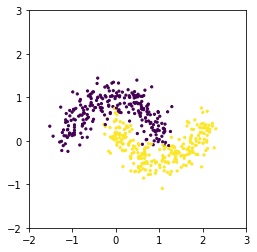

In [2]:
x_train, y_train = make_moons(n_samples=500, noise=0.2)
y_train = y_train[:, None]
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train.ravel(), s=5)
plt.xlim(-2, 3)
plt.ylim(-2, 3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [3]:
class NeuralNetwork(bn.Network):
    
    def __init__(self, n_input, n_hidden, n_output=1):
        super().__init__()
        with self.set_parameter():
            self.w1 = np.random.randn(n_input, n_hidden)
            self.b1 = np.zeros(n_hidden)
            self.w2 = np.random.randn(n_hidden, n_hidden)
            self.b2 = np.zeros(n_hidden)
            self.w3 = np.random.randn(n_hidden, n_output)
            self.b3 = np.zeros(n_output)

    def __call__(self, x, y=None):
        h = bn.tanh(x @ self.w1 + self.b1)
        h = bn.tanh(h @ self.w2 + self.b2)
        self.py = bn.random.Bernoulli(logit=h @ self.w3 + self.b3, data=y)
        return self.py.mu.value

In [4]:
model = NeuralNetwork(2, 5, 1)
optimizer = bn.optimizer.Adam(model, 0.1)
optimizer.set_decay(0.9, 100)

for i in range(2000):
    model.clear()
    model(x_train, y_train)
    log_likelihood = model.log_pdf()
    log_likelihood.backward()
    optimizer.update()

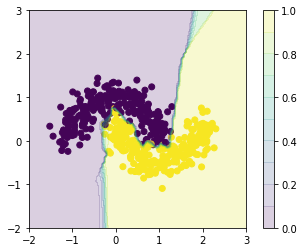

In [5]:
x_grid = np.mgrid[-2:3:100j, -2:3:100j]
x1, x2 = x_grid[0], x_grid[1]
x_grid = x_grid.reshape(2, -1).T

y_grid = model(x_grid).reshape(100, 100)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train.ravel())
plt.contourf(x1, x2, y_grid, np.linspace(0, 1, 11), alpha=0.2)
plt.colorbar()
plt.xlim(-2, 3)
plt.ylim(-2, 3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [6]:
class BayesianNetwork(bn.Network):
    
    def __init__(self, n_input, n_hidden, n_output=1):
        super().__init__()
        with self.set_parameter(), self.set_prior_dist():
            self.w1_mu = np.zeros((n_input, n_hidden))
            self.w1_s = np.zeros((n_input, n_hidden))
            self.b1_mu = np.zeros(n_hidden)
            self.b1_s = np.zeros(n_hidden)
            self.w2_mu = np.zeros((n_hidden, n_hidden))
            self.w2_s = np.zeros((n_hidden, n_hidden))
            self.b2_mu = np.zeros(n_hidden)
            self.b2_s = np.zeros(n_hidden)
            self.w3_mu = np.zeros((n_hidden, n_output))
            self.w3_s = np.zeros((n_hidden, n_output))
            self.b3_mu = np.zeros(n_output)
            self.b3_s = np.zeros(n_output)
            self.prior = bn.random.Gaussian(0, 1)

    def __call__(self, x, y=None):
        self.qw1 = bn.random.Gaussian(
            self.w1_mu, bn.softplus(self.w1_s),
            p=self.prior
        )
        self.qb1 = bn.random.Gaussian(
            self.b1_mu, bn.softplus(self.b1_s),
            p=self.prior
        )
        self.qw2 = bn.random.Gaussian(
            self.w2_mu, bn.softplus(self.w2_s),
            p=self.prior
        )
        self.qb2 = bn.random.Gaussian(
            self.b2_mu, bn.softplus(self.b2_s),
            p=self.prior
        )
        self.qw3 = bn.random.Gaussian(
            self.w3_mu, bn.softplus(self.w3_s),
            p=self.prior
        )
        self.qb3 = bn.random.Gaussian(
            self.b3_mu, bn.softplus(self.b3_s),
            p=self.prior
        )
        h = bn.tanh(x @ self.qw1.draw() + self.qb1.draw())
        h = bn.tanh(h @ self.qw2.draw() + self.qb2.draw())
        self.py = bn.random.Bernoulli(logit=h @ self.qw3.draw() + self.qb3.draw(), data=y)
        return self.py.mu.value

In [7]:
model = BayesianNetwork(2, 5, 1)
optimizer = bn.optimizer.Adam(model, 0.1)
optimizer.set_decay(0.9, 100)

for i in range(2000):
    model.clear()
    model(x_train, y_train)
    elbo = model.elbo()
    elbo.backward()
    optimizer.update()

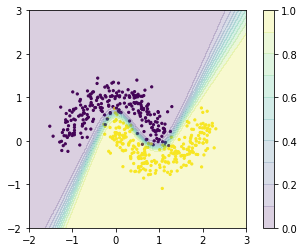

In [8]:
x_grid = np.mgrid[-2:3:100j, -2:3:100j]
x1, x2 = x_grid[0], x_grid[1]
x_grid = x_grid.reshape(2, -1).T

y_grid = np.mean([model(x_grid).reshape(100, 100) for _ in range(100)], axis=0)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train.ravel(), s=5)
plt.contourf(x1, x2, y_grid, np.linspace(0, 1, 11), alpha=0.2)
plt.colorbar()
plt.xlim(-2, 3)
plt.ylim(-2, 3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()